### Load data

In [9]:
import warnings
warnings.filterwarnings('ignore')
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
import IPython.display as ipd

from math import sqrt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import Lasso, ElasticNet, Ridge
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

import pickle

In [2]:
DATASET_DIR = 'PMEmo/dataset/PMEmo2019'

def load_static_features():
    features_csv = os.path.join(DATASET_DIR, 'features', 'static_features.csv')
    static_features= pd.read_csv(features_csv, index_col=0)
    return static_features

def load_static_features_and_valence():
    static_features = load_static_features()
    valence_csv = os.path.join(DATASET_DIR, 'annotations', 'static_annotations.csv')
    valence = pd.read_csv(valence_csv, index_col=0, usecols=['musicId','Valence(mean)'])
    return static_features.join(valence).dropna()

def load_static_features_and_arousal():
    static_features = load_static_features()
    arousal_csv = os.path.join(DATASET_DIR, 'annotations', 'static_annotations.csv')
    arousal = pd.read_csv(arousal_csv, index_col=0, usecols=['musicId','Arousal(mean)'])
    return static_features.join(arousal).dropna()

def load_audio_dataset(data):
    features = data[data.columns[:-1]].values
    labels = data[data.columns[-1]].values
#     scaler = StandardScaler(copy=False)
#     scaler.fit_transform(features)
    return features, labels

In [3]:
print('In Arousal dimension...')
data_a = load_static_features_and_arousal()
features_a, labels_a = load_audio_dataset(data_a)
print(features_a.shape, labels_a.shape)

In Arousal dimension...
(767, 6373) (767,)


In [4]:
print('In Valence dimension...')
data_v = load_static_features_and_valence()
features_v, labels_v = load_audio_dataset(data_v)
print(features_v.shape, labels_v.shape)

In Valence dimension...
(767, 6373) (767,)


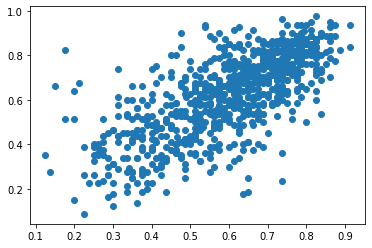

In [5]:
plt.scatter(labels_v, labels_a)

### Find the best estimator

In [6]:
def rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))


regressors = {
    'Lasso': Lasso(),
    'ElasticNet': ElasticNet(),
    'Ridge': Ridge(),
    'kNN': KNeighborsRegressor(),
    'SVRrbf': SVR(kernel='rbf', gamma='scale'),
    'SVRpoly': SVR(kernel='poly', gamma='scale'),
    'SVRlinear': SVR(kernel='linear', gamma='scale'),
    'DT': DecisionTreeRegressor(max_depth=5),
    'RF': RandomForestRegressor(max_depth=5, n_estimators=10, max_features=1)
}

# Standardize features by removing the mean and scaling to unit variance
prefunc = [StandardScaler()]

In [7]:

def cross_val_regression(regressors, features, labels, preprocessfunc):
    columns = list(regressors.keys())
    scores = pd.DataFrame(columns=columns, index=['RMSE'])
    for reg_name, reg in tqdm_notebook(regressors.items(), desc='regressors'):
        scorer = {'rmse': make_scorer(rmse)}
        reg = make_pipeline(*preprocessfunc, reg)
        reg_score = cross_validate(reg, features, labels, scoring=scorer, cv=10, return_train_score=False) 
        scores.loc['RMSE', reg_name] = reg_score['test_rmse'].mean()
#         scores.loc['R', reg_name] = reg_score['test_r'].mean()

    mean_rmse = scores.mean(axis=1)
    std_rmse = scores.std(axis=1)
    
    scores['Mean'] = mean_rmse
    scores['std'] = std_rmse
    return scores

def format_scores(scores):
    def highlight(s):
        is_min = s == min(s)
#         is_max = s == max(s)
#         is_max_or_min = (is_min | is_max)
        return ['background-color: yellow' if v else '' for v in is_min]
    scores = scores.style.apply(highlight, axis=1, subset=pd.IndexSlice[:, :scores.columns[-2]])
    return scores.format('{:.3f}')



In [8]:
print('In Arousal dimension...')
scores_a_a = cross_val_regression(regressors, features_a, labels_a, prefunc)
ipd.display(format_scores(scores_a_a))

print('In Valence dimension...')
scores_a_v = cross_val_regression(regressors, features_v, labels_v, prefunc)
ipd.display(format_scores(scores_a_v))

In Arousal dimension...


regressors:   0%|          | 0/9 [00:00<?, ?it/s]

,Lasso,ElasticNet,Ridge,kNN,SVRrbf,SVRpoly,SVRlinear,DT,RF,Mean,std
RMSE,0.184,0.184,0.140,0.136,0.119,0.227,0.110,0.132,0.157,0.154,0.038


In Valence dimension...


regressors:   0%|          | 0/9 [00:00<?, ?it/s]

,Lasso,ElasticNet,Ridge,kNN,SVRrbf,SVRpoly,SVRlinear,DT,RF,Mean,std
RMSE,0.162,0.162,0.163,0.135,0.121,0.225,0.122,0.139,0.140,0.152,0.032


### Train the model on whole dataset using best estimator

In [13]:
arousal_model = make_pipeline(*prefunc, SVR(kernel='linear', gamma='scale'))
arousal_model.fit(features_a, labels_a)
with open(os.path.join('features/emotions/tmp', 'svr_linear_arousal.pkl') , 'wb') as fid:
    pickle.dump(arousal_model, fid)

In [14]:
valence_model = make_pipeline(*prefunc, SVR(kernel='linear', gamma='scale'))
valence_model.fit(features_v, labels_v)
with open(os.path.join('features/emotions/tmp', 'svr_linear_valence.pkl') , 'wb') as fid:
    pickle.dump(valence_model, fid)

### Use the best fold from SVR Linear to predict Arousal

In [9]:
scorer = {'rmse': make_scorer(rmse)}
reg = make_pipeline(*prefunc, SVR(kernel='linear', gamma='scale'))
reg_score = cross_validate(reg, features_a, labels_a, scoring=scorer, cv=10, return_train_score=False, return_estimator=True) 

In [10]:
best_idx = np.argmin(reg_score['test_rmse'])
best_model = reg_score['estimator'][best_idx] 
predictions_a = best_model.predict(features_a)

### Use the best fold from SVR Linear to predict Valence

In [11]:
scorer = {'rmse': make_scorer(rmse)}
reg = make_pipeline(*prefunc, SVR(kernel='linear', gamma='scale'))
reg_score = cross_validate(reg, features_v, labels_v, scoring=scorer, cv=10, return_train_score=False, return_estimator=True) 

In [12]:
best_idx = np.argmin(reg_score['test_rmse'])
best_model = reg_score['estimator'][best_idx] 
predictions_v = best_model.predict(features_v)

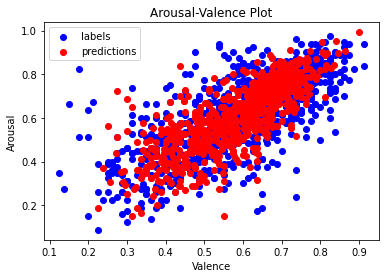

In [13]:
plt.title('Arousal-Valence Plot')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.scatter(labels_v, labels_a, c='b', label='labels')
plt.scatter(predictions_v, predictions_a, c='r',  label='predictions')
plt.legend(loc='upper left')
plt.show()

### Train on balanced data

In [14]:
def balance_labels(feature_a, feature_v, label_a, label_v, seed):

    ''' evenly select same amount of points in four quadrant'''

    threshold_a, threshold_v = 0.5, 0.5

    quadrant_dict = {'quadrant_1': [], 'quadrant_2': [], 'quadrant_3': [], 'quadrant_4': []}
    # distribute to groups
    for idx in range(len(label_a)):
        if label_a[idx] >= threshold_a and label_v[idx] >= threshold_v:
            quadrant_dict['quadrant_1'].append(idx)
        elif label_a[idx] >= threshold_a and label_v[idx] < threshold_v:
            quadrant_dict['quadrant_2'].append(idx)
        elif label_a[idx] < threshold_a and label_v[idx] < threshold_v:
            quadrant_dict['quadrant_3'].append(idx)
        elif label_a[idx] < threshold_a and label_v[idx] >= threshold_v:
            quadrant_dict['quadrant_4'].append(idx)
        
    balanced_quadrant_size = 1000
    for quadrant, quadrant_idx in quadrant_dict.items():
        if len(quadrant_idx) < balanced_quadrant_size:
            balanced_quadrant_size = len(quadrant_idx)
        print('size of {}: {} '.format(quadrant, len(quadrant_idx)))
    print('size of balanced quadrants: {}'.format(balanced_quadrant_size))

    balanced_idx = []
    for quadrant, quadrant_idx in quadrant_dict.items():
        np.random.seed(seed)
        np.random.shuffle(quadrant_idx)
        balanced_idx.extend(quadrant_idx[:balanced_quadrant_size]) 
    balanced_idx = np.array(balanced_idx)
    # balanced_idx.sort()喔
    return feature_v[balanced_idx], feature_a[balanced_idx], label_v[balanced_idx], labels_a[balanced_idx]


In [15]:
seed = 682
balanced_feature_v, balanced_feature_a, balanced_label_v, balanced_label_a = balance_labels(features_a, features_v, labels_a, labels_v, seed)

size of quadrant_1: 505 
size of quadrant_2: 73 
size of quadrant_3: 132 
size of quadrant_4: 57 
size of balanced quadrants: 57


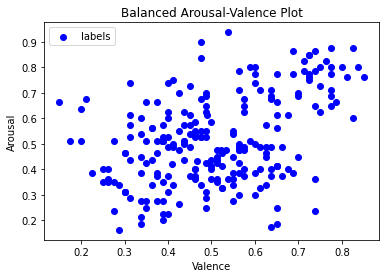

In [16]:
plt.title('Balanced Arousal-Valence Plot')
plt.xlabel('Valence')
plt.ylabel('Arousal')
plt.scatter(balanced_label_v, balanced_label_a, c='b', label='labels')
plt.legend(loc='upper left')
plt.show()

In [17]:
Labels = np.array([[labels_a[i], labels_v[i]] for i in range(len(labels_a))])
Features = np.array([[features_a[i], features_v[i]] for i in range(len(features_a))])

In [18]:
Features.shape, Labels.shape

((767, 2, 6373), (767, 2))

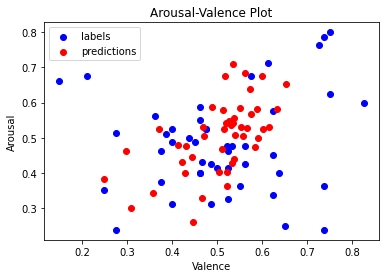

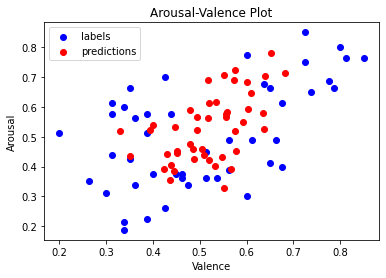

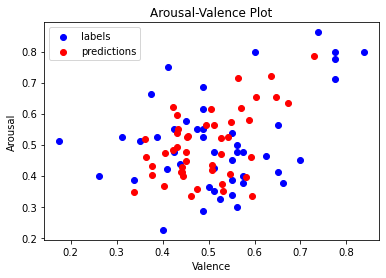

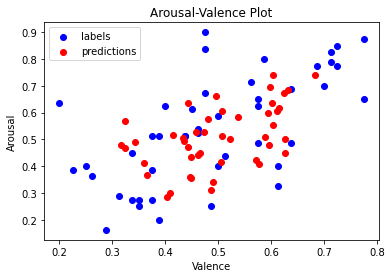

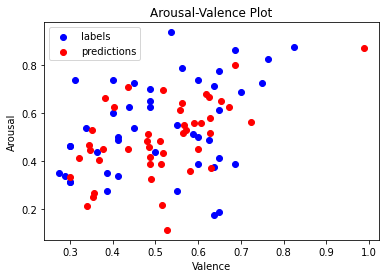

In [22]:
kf = KFold(n_splits=5, shuffle=True)
for train_index, test_index in kf.split(balanced_feature_a):
    # print("TRAIN:", train_index, "TEST:", test_index)
    features_a_train, features_a_test = balanced_feature_a[train_index], balanced_feature_a[test_index]
    labels_a_train, labels_a_test = balanced_label_a[train_index], balanced_label_a[test_index]
    
    scorer = {'rmse': make_scorer(rmse)}
    reg = make_pipeline(*prefunc, SVR(kernel='linear', gamma='scale'))
    # reg_score = cross_validate(reg, features_a_train, labels_a_train, scoring=scorer, cv=1, return_train_score=False, return_estimator=True) 
    # best_idx = np.argmin(reg_score['test_rmse'])
    # best_model = reg_score['estimator'][best_idx] 
    # predictions_a = best_model.predict(features_a_test)
    reg.fit(features_a_train, labels_a_train)
    predictions_a = reg.predict(features_a_test)


    features_v_train, features_v_test = balanced_feature_v[train_index], balanced_feature_v[test_index]
    labels_v_train, labels_v_test = balanced_label_v[train_index], balanced_label_v[test_index]
    
    scorer = {'rmse': make_scorer(rmse)}
    reg = make_pipeline(*prefunc, SVR(kernel='linear', gamma='scale'))
    # reg_score = cross_validate(reg, features_v_train, labels_v_train, scoring=scorer, cv=1, return_train_score=False, return_estimator=True) 
    # best_idx = np.argmin(reg_score['test_rmse'])
    # best_model = reg_score['estimator'][best_idx] 
    # predictions_v = best_model.predict(features_v_test)
    reg.fit(features_v_train, labels_v_train)
    predictions_v = reg.predict(features_v_test)


    plt.figure()
    plt.title('Arousal-Valence Plot')
    plt.xlabel('Valence')
    plt.ylabel('Arousal')
    plt.scatter(labels_v_test, labels_a_test, c='b', label='labels')
    plt.scatter(predictions_v, predictions_a, c='r',  label='predictions')
    plt.legend(loc='upper left')
    plt.show()